# Autoencoders

![autoencoder](notebook_images/autoencoder.jpg)

### References:

Deconvolution and Checkerboard Artifacts - https://distill.pub/2016/deconv-checkerboard/https://distill.pub/2016/deconv-checkerboard/

Some of the code has been taken from https://www.pyimagesearch.com/2020/03/30/autoencoders-for-content-based-image-retrieval-with-keras-and-tensorflow/

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras

import math
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

import os

import cv2


## Auxiliary functions

In [2]:
def show_preds_3(set1, set2, set3, count):
  columns = 6
  rows = int(count*3 / columns) + 1  
  plt.figure(figsize=(15, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*3+1)
      plt.title("original")
      plt.imshow(set1[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*3+2)
      plt.title("reconst")
      plt.imshow(set2[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*3+3)
      plt.title("noisy")
      plt.imshow(set3[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')

def show_preds(set1, set2, count):
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(set1[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(set2[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')    
        
def plot_scatter(x,y,train_Y):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = train_Y, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()

    # assumes len samples is a perfect square
def show_samples(samples):
    
    k = int(math.sqrt(len(samples)))
    fig = plt.figure(figsize=(k,k))
    
    for i in range(len(samples)):
        plt.subplot(k, k, i+1)
        plt.imshow(np.asarray(samples)[i, :, :, 0], cmap='gray')
        plt.axis('off')    

def show_content_retrieval(train_X, top50):

    fig = plt.figure(figsize=(10,50))
    for i in range(len(top50)):
        ax = plt.subplot(25,5,i+1)
        plt.imshow(train_X[top50[i][1]], cmap='gray')
        plt.title(f'{top50[i][0]:.3f}')
        plt.axis('off')        


def load_and_prepare_image(file):


    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28,28))

    dataImage = np.asarray(image).astype('float32') / 255.0
    dataImage = np.expand_dims(dataImage, axis=-1)
    dataImage = np.expand_dims(dataImage, axis=0)

    return dataImage



def show_pair(a,b):
    fig = plt.figure(figsize=(5, 10))
    ax = plt.subplot(1, 2, 1 )
    plt.imshow(a, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    ax = plt.subplot(1, 2, 2 )
    plt.imshow(b, cmap=plt.get_cmap('gray'))
    plt.axis('off')    


def show_anomaly_sample(image, recon, err):
        plt.figure(figsize=(5,2))
        ax = plt.subplot(1,2,1)
        plt.imshow(image, cmap='gray')
        plt.title(str(err))
        ax = plt.subplot(1,2,2)
        plt.imshow(recon, cmap='gray')
        plt.axis('off')

## Configuration

In [3]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

model_path = 'd:/vcpi/DL07/autoencoder_mnist'

train_online = False

### Load and prepare MNIST dataset

In [4]:
((train_X, train_Y), (test_X, test_Y)) = mnist.load_data()

# change shape to have each pixel in a separate dimension
train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)

# rescale inputs
train_X = train_X.astype("float32") / 255.0
test_X = test_X.astype("float32") / 255.0

print('Train shape: ',train_X.shape)
print('Test shape:  ', test_X.shape)

Train shape:  (60000, 28, 28, 1)
Test shape:   (10000, 28, 28, 1)


# Autoencoder for reconstruction

![reconstruction](notebook_images/autoencoder_reconstruction.jpg)

## Architecture

In [5]:
inputs = Input(shape = (WIDTH, HEIGHT, NUM_CHANNELS))
    
# Encoder    
x = Conv2D(32, (3, 3), strides=2, padding="same")(inputs)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

volumeSize = x.shape
x = Flatten()(x)

# Latent space
latent = Dense(LATENT_SPACE_DIM, name="latent")(x)

encoder = Model(inputs, latent, name="encoder")
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                           

In [6]:
#decoder
latentInputs = Input(shape=(LATENT_SPACE_DIM,))
y = Dense(np.prod(volumeSize[1:]))(latentInputs)
y = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(y)

y = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization()(y) 

y = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization()(y)    

y = Conv2DTranspose(NUM_CHANNELS, (3, 3), padding="same")(y)
outputs = Activation("sigmoid", name="decoded")(y)

decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                           

In [7]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 25474     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65473     
                                                                 
Total params: 90,947
Trainable params: 90,563
Non-trainable params: 384
_________________________________________________________________


## Prepare and train model

In [8]:
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

In [9]:
EPOCHS = 25

if train_online:
# train the convolutional autoencoder
    history = autoencoder.fit(
        train_X, train_X,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE)


## Save models

In [10]:
if train_online:

    encoder.save(f'{model_path}/encoder{LATENT_SPACE_DIM}.h5')
    decoder.save(f'{model_path}/decoder{LATENT_SPACE_DIM}.h5')
    autoencoder.save(f'{model_path}/autoencoder{LATENT_SPACE_DIM}.h5')

## Load Models for a particular latent space dim

In [11]:
#LATENT_SPACE_DIM = 16

autoencoder = load_model(f'{model_path}/autoencoder{LATENT_SPACE_DIM}.h5')
encoder = load_model(f'{model_path}/encoder{LATENT_SPACE_DIM}.h5')
decoder = load_model(f'{model_path}/decoder{LATENT_SPACE_DIM}.h5')


## Apply model to the test set and visualize some results

313/313 [==============================] - 5s 3ms/step


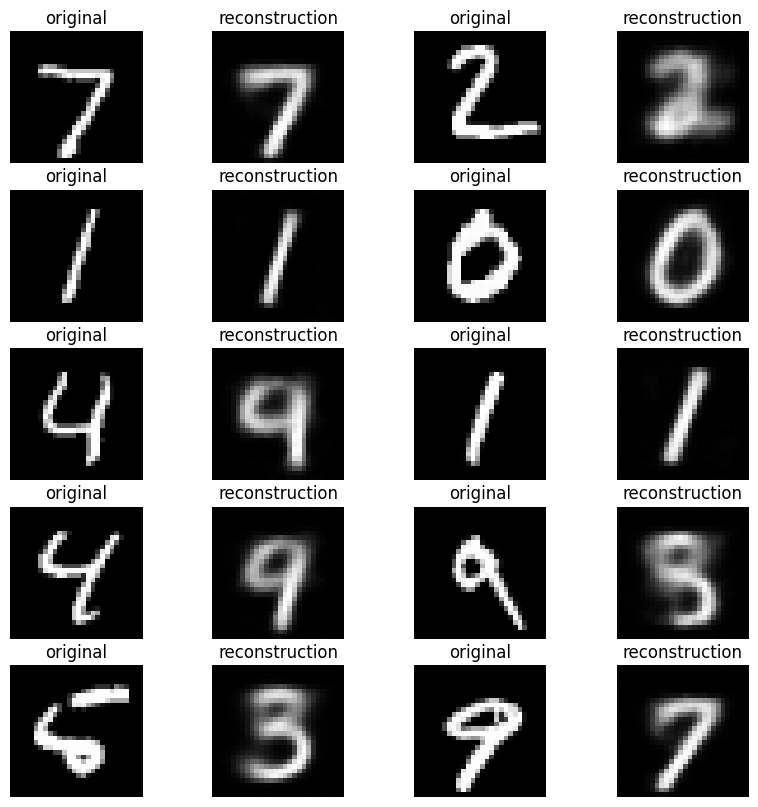

In [12]:
recon = autoencoder.predict(test_X)
show_preds(test_X, recon, 10)

1875/1875 [==============================] - 2s 1ms/step


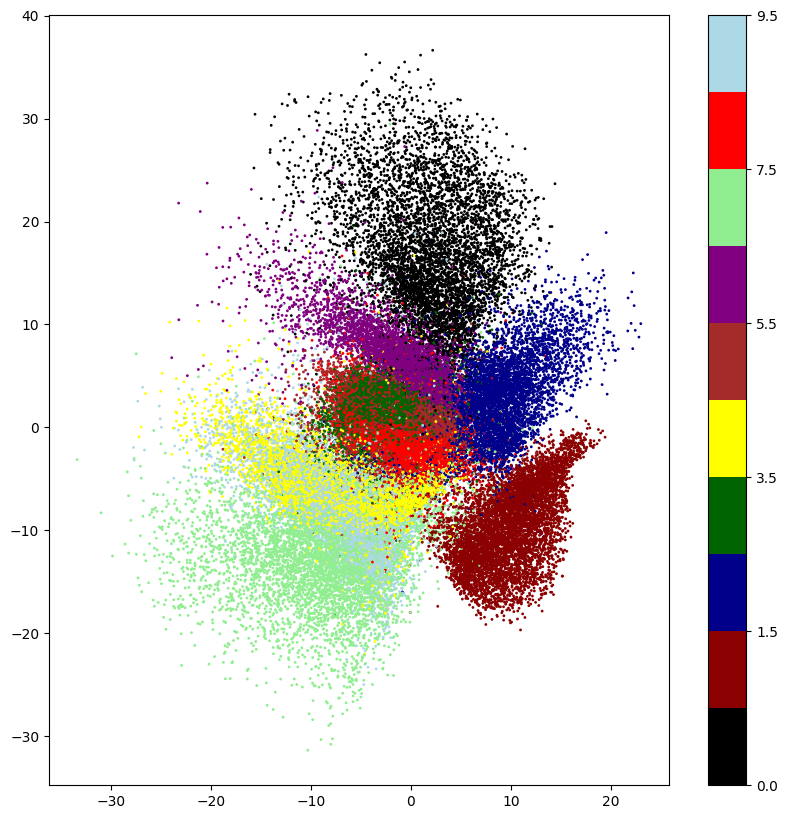

In [13]:
if LATENT_SPACE_DIM == 2:

    encoded = encoder.predict(train_X)
    
    x = np.array(encoded)[:,0]
    y = np.array(encoded)[:,1]

    plot_scatter(x,y,train_Y)


1/1 [==============================] - 0s 182ms/step


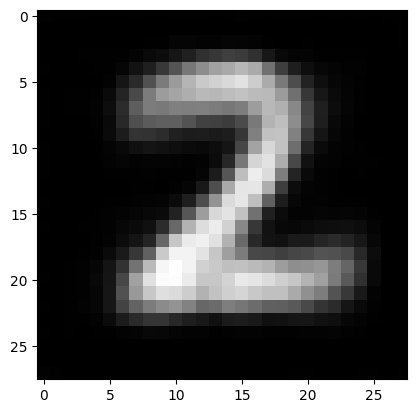

In [14]:
if LATENT_SPACE_DIM == 2:
    pred = decoder.predict([[10, 0]])
    plt.imshow(pred[0], cmap = 'gray')

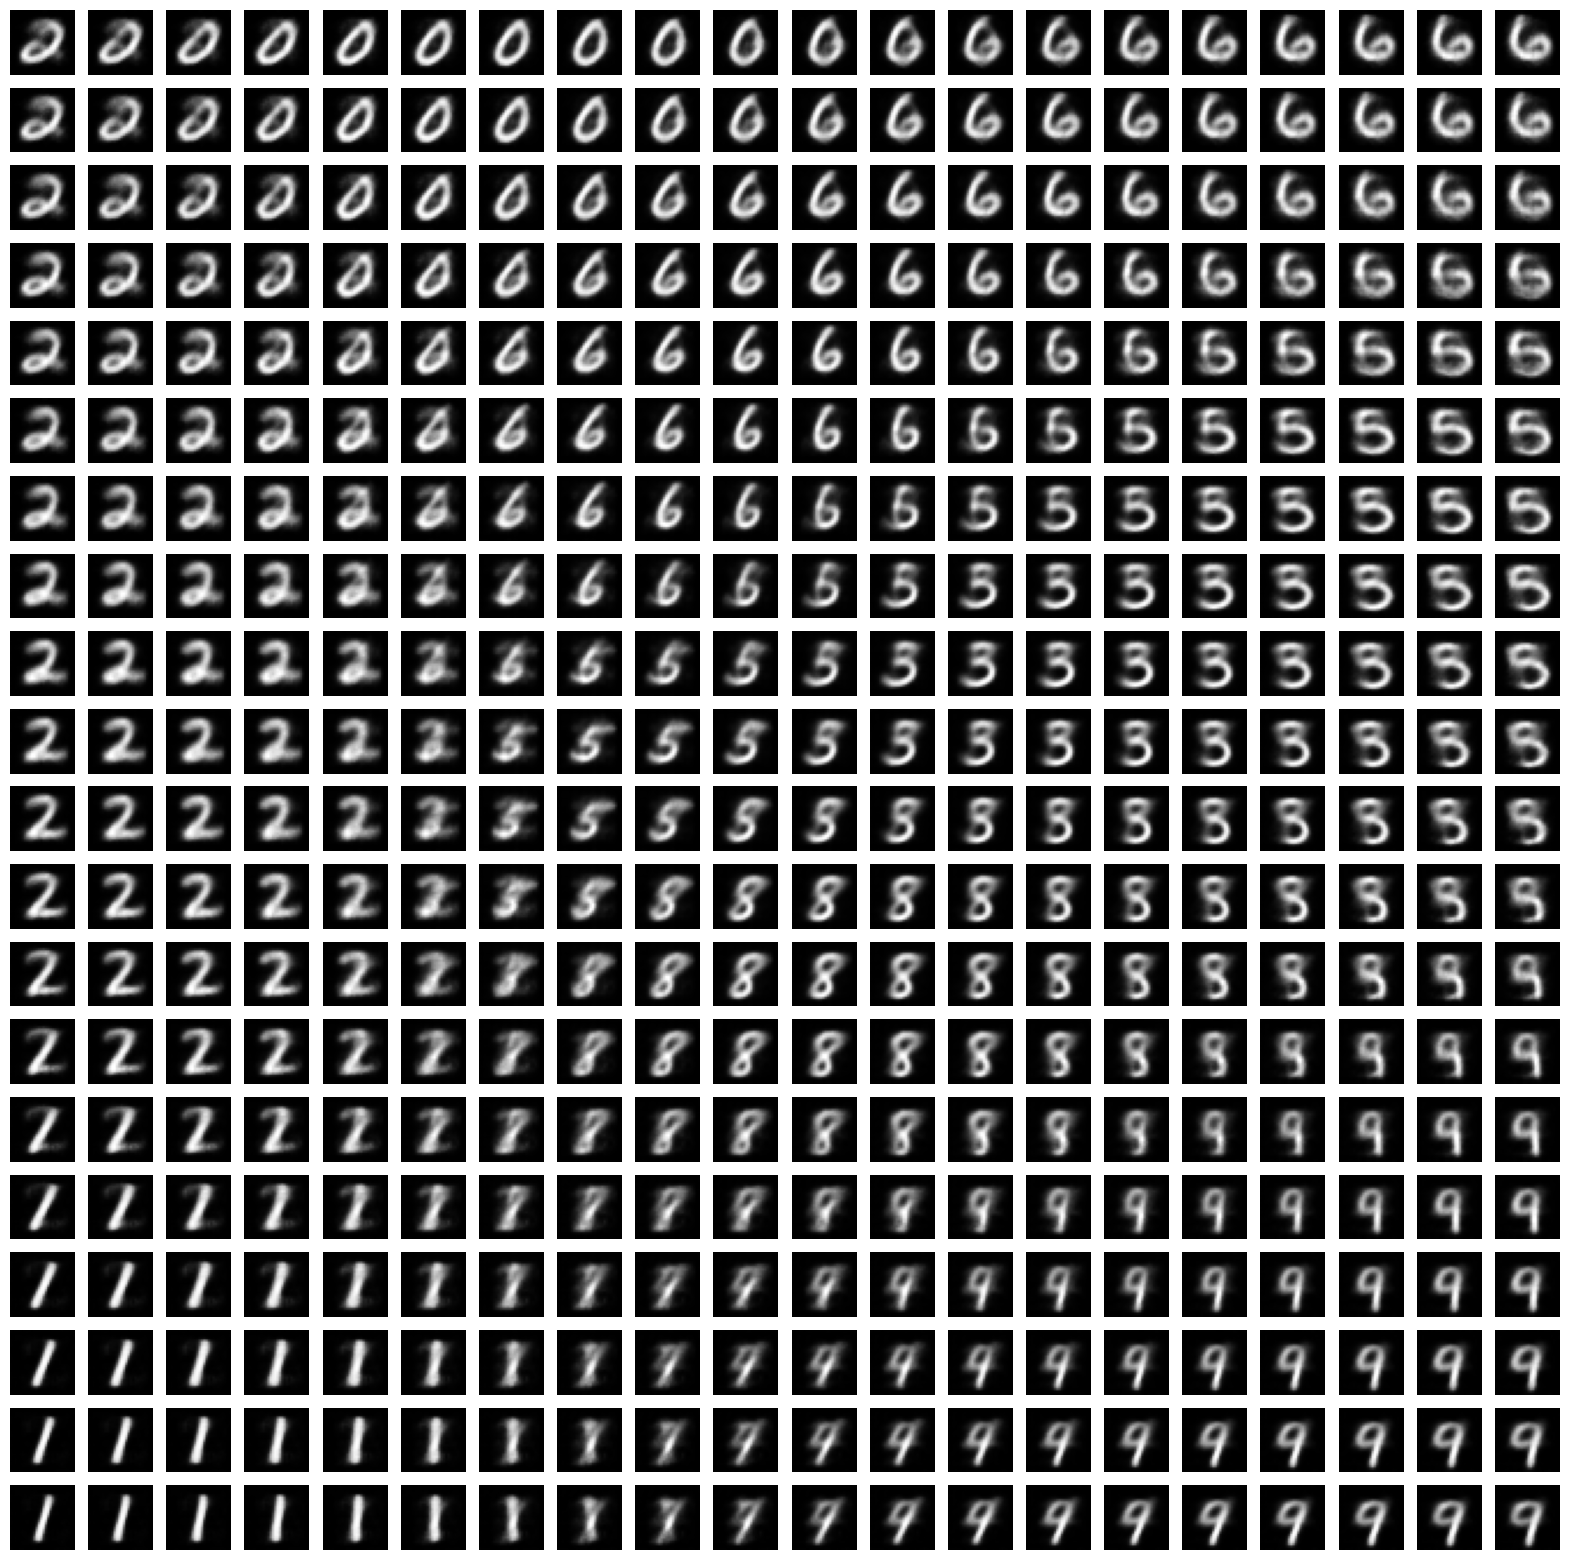

In [15]:
if LATENT_SPACE_DIM == 2:
    limit = 10
    steps = 20

    step = (2.0 * limit) / steps

    vector_generation = [[limit - j*step, limit - i*step] 
                                for i in range(steps) for j in range(steps)]

    predictions = decoder(np.asarray(vector_generation))

    show_samples(predictions)

## Results with different latent space dimensions

![varying latent space dimension](notebook_images/varying_latent_space.jpg)

# Anomaly Detection

Check if an image is consistent with the training set

![anomaly detection test](notebook_images/anomaly_detection.jpg)

Image is fed in the autoencoder, and the reconstruction is retrieved. It is expected for images not consistent with the training set that a larger reconstruction error is obtained

1/1 [==============================] - 0s 17ms/step


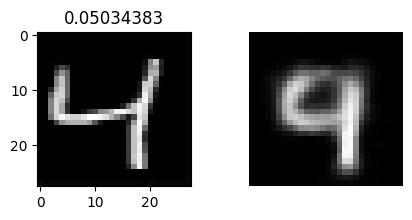

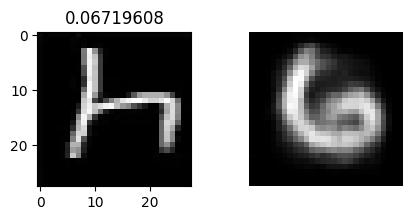

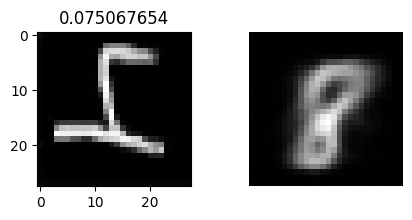

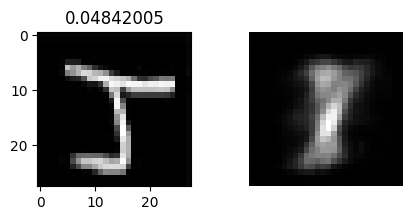

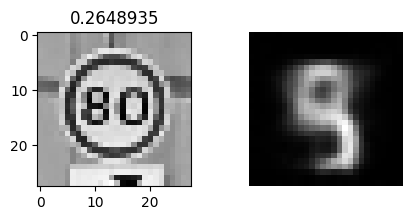

In [16]:
def anomalyDetection(image_path):

    files = os.listdir(image_path)
    for f in files:
        
        data = load_and_prepare_image(os.path.join(image_path, f))

        testing = autoencoder.predict([data])
        err = np.mean((data - testing) ** 2)

        show_anomaly_sample(data[0], testing.squeeze(), err)


image_path = 'anomalyDetectionImages'
anomalyDetection(image_path)

# Image Based Content Retrieval

In [17]:
# get latent space for training set
features = encoder.predict(train_X)

# build a dict from index to features from latent_space
indexes = list(range(0, train_X.shape[0]))
data = {"indexes": indexes, "features": features}

1875/1875 [==============================] - 2s 1ms/step


1/1 [==============================] - 0s 58ms/step


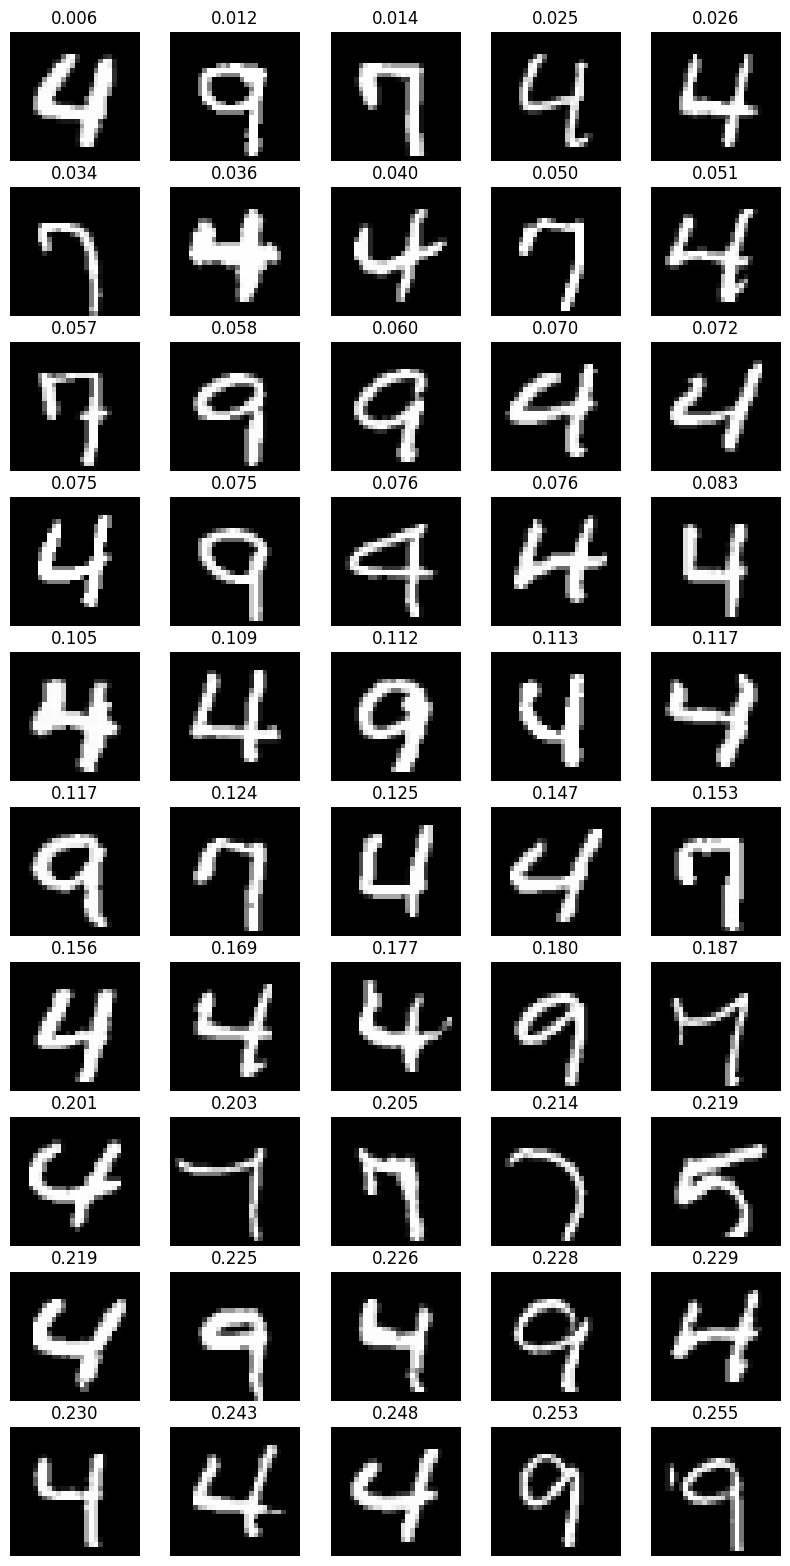

In [18]:
image_path = 'contentRetrievalImages'

dataImage = load_and_prepare_image(os.path.join(image_path, '4.jpg'))

#predict
dataLatent = encoder.predict(dataImage).squeeze()

# compute mse error in latent space between image and elements from training set
results = []
for i in range(len(data['indexes'])) :    
    err = np.sum((dataLatent - data['features'][i])**2)
    err /= float(dataLatent.shape[0])
    results.append([err, i])

# sort images by error    
top50 = sorted(results)[:50]

show_content_retrieval(train_X, top50) 

# Denoiser

![denoiser](notebook_images/autoencoder_denoiser.jpg)

## Create noisy train and test data

In [19]:
noisyTrain = train_X.copy()
noisyTest = test_X.copy()

In [20]:
prob = 0.1

for i in range(len(noisyTrain)):
    probs = np.random.random(noisyTrain.shape[1:])
    noisyTrain[i][probs < (prob / 2)] = 0
    noisyTrain[i][probs > 1 - (prob / 2)] = 1
    
for i in range(len(noisyTest)):
    probs = np.random.random(noisyTrain.shape[1:])
    noisyTest[i][probs < (prob / 2)] = 0
    noisyTest[i][probs > 1 - (prob / 2)] = 1

## Show an image from the noisy training set

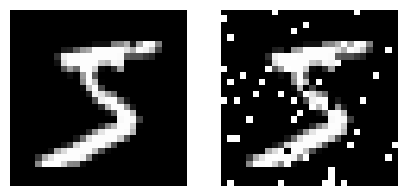

In [21]:
show_pair(train_X[0], noisyTrain[0])    

## Train the autoencoder with the noisy data

In [22]:
if train_online:
    # train the convolutional autoencoder
    history = autoencoder.fit(
        noisyTrain, train_X,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE)
    
    autoencoder.save(f'{model_path}/autoencoder_{LATENT_SPACE_DIM}_denoise.h5')


## Load the autoencoder

In [23]:
autoencoder = load_model(f'{model_path}/autoencoder_{LATENT_SPACE_DIM}_denoise.h5')

## Apply denoiser to test data

313/313 [==============================] - 1s 2ms/step


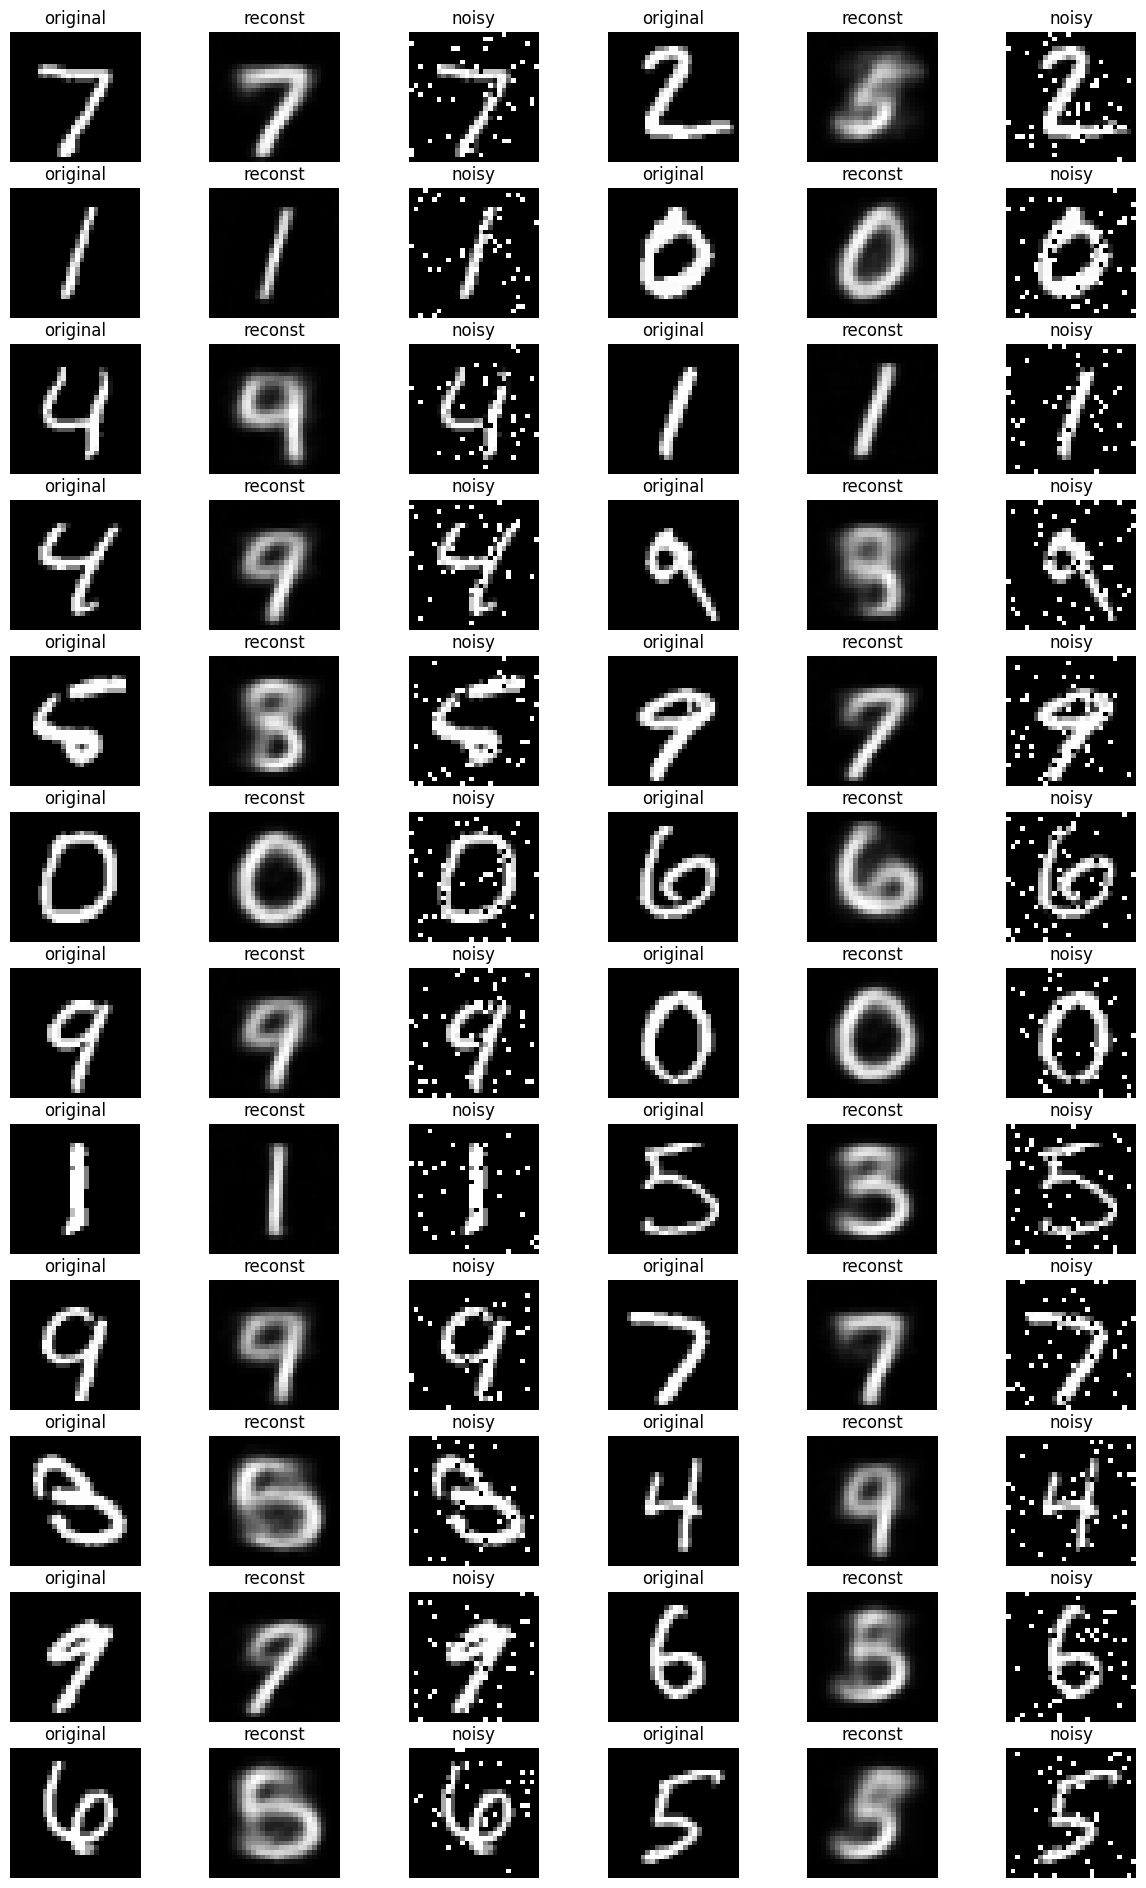

In [24]:
recon = autoencoder.predict(noisyTest)
show_preds_3(test_X, recon, noisyTest, 24)   